<a href="https://colab.research.google.com/github/avishek-astra/Deep-Learning-Projects/blob/main/CNNmilestone_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

#for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [6]:
#use GPU if availabel
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Import a dataset

In [7]:
#transformation
transfrom=T.Compose([T.ToTensor(),T.Normalize([.5,.5,.5],[.5,.5,.5])])\
#import the data and simulataneously and the transform
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transfrom)
devtest=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transfrom)


#split the devtest into two separate sets
randidx=np.random.permutation(10000)
devset=Subset(devtest,randidx[:6000])
testset=Subset(devtest,randidx[6000:])


#transfrom to dataLoaders
batchsize=32
train_loader=DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader=DataLoader(devset,batch_size=batchsize)
test_loader=DataLoader(testset,batch_size=len(testset))

100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s]


In [8]:
#check out the shape of the datasets
print('Datashapes(train/dev/test):')
print(len(trainset))
print(len(devset))
print(len(testset))

#and the range of pixel intensity values
print('\n Data value range:')
print(np.min(trainset.data),np.max(trainset.data))

#the unique categories
print('\nData categories')
print(trainset.classes)

Datashapes(train/dev/test):
50000
6000
4000

 Data value range:
0 255

Data categories
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
#Uh oh! It looks lik ethe images are the wrong dimensions
#they need to be 3X32x32
#and they are not normalized


#but.....
X,y=next(iter(train_loader))

#try again
print('Data shapes(train/test):')
print(X.data.shape)
#and the range of pixel intensity values
print(torch.max(X.data),torch.max(X.data))

Data shapes(train/test):
torch.Size([32, 3, 32, 32])
tensor(1.) tensor(1.)


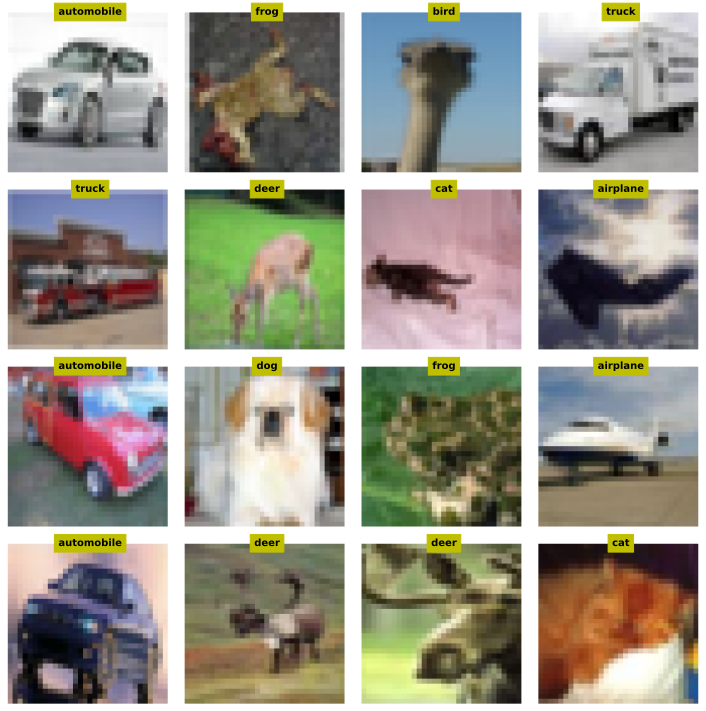

In [10]:
#inspect a few random images
fig,axs=plt.subplots(4,4,figsize=(10,10))
for (i,ax) in enumerate(axs.flatten()):
  #extract that image(need to transpose it back to 32X32x3)
  pic=X.data[i].numpy().transpose((1,2,0))
  pic=pic/2+.5
  #and its label
  label=trainset.classes[y[i]]

  #and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()


Create the DL model

In [11]:
#create a class for the model
def makeTheAENet(printtoggle=False):
  class aenet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      #print toggle
      self.print=printtoggle

      ###-----------feature map layers-----------###
      #first convolution layer
      self.encconv1=nn.Conv2d(3,16,4,padding=1,stride=2)
      #output size :(32+2*1-4)/2+1=16

      #second convolution layer
      self.encconv2=nn.Conv2d(16,32,4,padding=1,stride=2)
      #output size:(16+2*1-4)/2+1=8

      #third convolution layer
      self.latent=nn.Conv2d(32,64,4,padding=1,stride=2)
      #output size:(8+2*1-4)/2+1=4


      ###----------linear decision layers--------###

      #first convolution layer
      self.decconv1=nn.ConvTranspose2d(64,32,4,padding=1,stride=2)

      #second convolution layer
      self.decconv2=nn.ConvTranspose2d(32,16,4,padding=1,stride=2)

      #third convolution layer(output)
      self.output=nn.ConvTranspose2d(16,3,4,padding=1,stride=2)

    def forward(self,x):

      if self.print:print(f'Input:{list(x.shape)}')

      #first block:convolution->maxpool->batchnorm->relu
      x=F.leaky_relu(self.encconv1(x))

      if self.print:print(f'First CPBR block:{list(x.shape)}')

      #second block:convolution ->maxpool->batchnorm->relu
      x=F.leaky_relu(self.encconv2(x))

      if self.print:print(f'Second CPBR block:{list(x.shape)}')
      #Third block:convolution ->maxpool->batchnorm->relu
      x=F.leaky_relu(self.latent(x))

      if self.print:print(f'Third CPBR block:{list(x.shape)}')

      #first decoder block
      x=F.leaky_relu(self.decconv1(x))

      if self.print:print(f'First decoder block:{list(x.shape)}')
      #second decoder block
      x=F.leaky_relu(self.decconv2(x))

      if self.print:print(f'Second decoder block:{list(x.shape)}')

      #output layer
      x=F.leaky_relu(self.output(x))

      if self.print:print(f'Output:{list(x.shape)}')

      return x

  #create the model instance
  net=aenet(printtoggle)

  #loss function
  lossfun=nn.MSELoss()

  #optimizer
  optimizer=torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)


  return net,lossfun,optimizer





In [12]:
#test the model with one batch
aenet,lossfun,optimizer=makeTheAENet(True)

X,y=next(iter(train_loader))
yHat=aenet(X)
#check size of output
print('\nOutput size:')
print(yHat.shape)

#check loss
loss=lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)


Input:[32, 3, 32, 32]
First CPBR block:[32, 16, 16, 16]
Second CPBR block:[32, 32, 8, 8]
Third CPBR block:[32, 64, 4, 4]
First decoder block:[32, 32, 8, 8]
Second decoder block:[32, 16, 16, 16]
Output:[32, 3, 32, 32]

Output size:
torch.Size([32, 3, 32, 32])
 
Loss:
tensor(0.2858, grad_fn=<MseLossBackward0>)


Create a function that trains the model

In [13]:
# a function that trains the model

def function2trainTheModel():
  #number of epochs
  numepochs=10

  #create a new model
  net,lossfun,optimizer=makeTheAENet()

  #send the model to the GPU
  net.to(device)

  #initialize losses
  trainLoss=torch.zeros(numepochs)
  devLoss=torch.zeros(numepochs)
  trainAcc=torch.zeros(numepochs)
  devAcc=torch.zeros(numepochs)

  #loop over epochs
  for epochi in range(numepochs):

    #loop over training data batches
    net.train()
    batchLoss=[]
    batchAcc=[]

    for X,y in train_loader:
      #push data to GPU
      X=X.to(device)
      y=y.to(device)

      #forward pass and loss
      yHat=net(X)
      loss=lossfun(yHat,X)

      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #loss and accuracy from this batch
      batchLoss.append(loss.item())
      #batchAcc.append(torch.mean((torch.argmax(yHat,axis=1)==X).float()).item())
    #end of batch loop...

    #and get average losses and accuracies across the batches
    trainLoss[epochi]=np.mean(batchLoss)
    #trainAcc[epochi]=100*np.mean(batchAcc)



    ###test performance (here done in batches!)
    net.eval() # switch to test mode
    batchAcc=[]
    batchLoss=[]
    for X,y in dev_loader:
      #push data to GPU
      X=X.to(device)
      y=y.to(device)

      #forward pass and loss
      with torch.no_grad():
        yHat=net(X)
        loss=lossfun(yHat,X)

      #loss and accuracy from this batch
      batchLoss.append(loss.item())
      #batchAcc.append(torch.mean((torch.argmax(yHat,axis=1)==X).float()).item())
    #end of batch loop...

    #and get average losses and accuracies across the batches
    devLoss[epochi]=np.mean(batchLoss)
    #devAcc[epochi]=100*np.mean(batchAcc)
  #end epochs

  #functin output
  return trainLoss,devLoss ,net # Return the trained model

Run the model and show the results!

In [14]:
#~2 minutes with 10 epochs on GPU
trainLoss,devLoss, trained_net = function2trainTheModel() # Capture the returned model

In [15]:
# the real test set!

trained_net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = trained_net(X) # Use the trained model
  loss = lossfun(yHat,X)

# loss and accuracy from this batch
testLoss = loss.item()
#testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

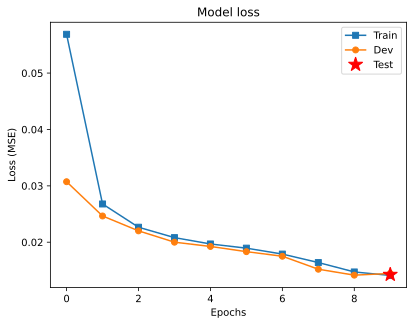

In [21]:
plt.plot(trainLoss,'s-',label='Train')
plt.plot(devLoss,'o-',label='Dev')
plt.plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)') # Updated ylabel to MSE as the loss function is MSELoss
plt.title('Model loss')
plt.legend() # Added legend to show labels
plt.show() # Ensure plot is displayed